In [1]:
import numpy as np
import h5py
import tensorflow as tf
import random


import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tempfile import TemporaryFile
from scipy.io import loadmat
import skfuzzy as fuzz

2024-03-18 10:35:43.883058: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 10:35:43.883088: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 10:35:43.884061: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-18 10:35:43.889615: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 10:35:44.511760: W tensorflow/comp

In [6]:

# Configuration
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Constants
path = "../DeepMIMOv2/Gan_Data/64ant_32sub_32pilot_548_560/Gan_0_dBOutdoor1_60_64ant_32subcs_32pilot.mat"

BATCH_SIZE = 64  # Batch size

NUM_EPOCHS = 100

In [3]:
def load_image_train(path, batch_size=BATCH_SIZE):
    """
    Load, jitter, and normalize training images.
    """
    with h5py.File(path, 'r') as file:
        real_image = np.transpose(np.array(file['output_da']))
        input_image = np.transpose(np.array(file['input_da']))

    batch_im = random.sample(range(real_image.shape[0]), real_image.shape[0])
    real_image, input_image = real_image[batch_im], input_image[batch_im]
    
    n_batches = int(real_image.shape[0] / batch_size)

    for i in range(n_batches - 1):
        yield real_image[i*batch_size:(i+1)*batch_size], input_image[i*batch_size:(i+1)*batch_size]


def load_image_test(path, batch_size=1):
    """
    Load and normalize test images.
    """
    with h5py.File(path, 'r') as file:
        real_image = np.transpose(np.array(file['output_da_test']))
        input_image = np.transpose(np.array(file['input_da_test']))

    n_batches = int(real_image.shape[0] / batch_size)

    for i in range(n_batches - 1):
        yield real_image[i*batch_size:(i+1)*batch_size], input_image[i*batch_size:(i+1)*batch_size]


def load_image_test_y(path):
    """
    Load test images.
    """
    with h5py.File(path, 'r') as file:
        real_image = np.transpose(np.array(file['output_da_test']))
        input_image = np.transpose(np.array(file['input_da_test']))

    return real_image, input_image


class EncoderLayer(tf.keras.Model):
    def __init__(self, filters, kernel_size, strides_s=2, apply_batchnorm=True, add=False, padding_s='same'):
        super(EncoderLayer, self).__init__()
        initializer = tf.random_normal_initializer(mean=0., stddev=0.02)
        conv = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides_s,
                             padding=padding_s, kernel_initializer=initializer, use_bias=False)
        ac = tf.keras.layers.LeakyReLU()

        components = [conv]
        if apply_batchnorm:
            components.append(tf.keras.layers.BatchNormalization())
            components.append(ac)
        
        self.encoder_layer = tf.keras.Sequential(components)

    def call(self, x):
        return self.encoder_layer(x)


class DecoderLayer(tf.keras.Model):
    def __init__(self, filters, kernel_size, strides_s=2, apply_dropout=False, add=False):
        super(DecoderLayer, self).__init__()
        initializer = tf.random_normal_initializer(mean=0., stddev=0.02)
        dconv = tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides_s,
                                       padding='same', kernel_initializer=initializer, use_bias=False)
        bn = tf.keras.layers.BatchNormalization()
        ac = tf.keras.layers.ReLU()

        components = [dconv, bn]
        if apply_dropout:
            components.append(tf.keras.layers.Dropout(rate=0.5))
        components.append(ac)
        
        self.decoder_layer = tf.keras.Sequential(components)

    def call(self, x):
        return self.decoder_layer(x)


class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()

        # Resize Input
        # self.p_layers = [
        #     DecoderLayer(filters=2, kernel_size=4, strides_s=2, add=True),
        #     DecoderLayer(filters=2, kernel_size=4, strides_s=2, add=True),
        #     EncoderLayer(filters=2, kernel_size=(6,1), strides_s=(4,1), add=True)
        # ]

        # Encoder
        self.encoder_layers = [
            EncoderLayer(filters=64*1, kernel_size=4, apply_batchnorm=False),
            EncoderLayer(filters=64*2, kernel_size=4),
            EncoderLayer(filters=64*4, kernel_size=4),
            EncoderLayer(filters=64*8, kernel_size=4),
            EncoderLayer(filters=64*8, kernel_size=4)
        ]

        # Decoder
        self.decoder_layers = [
            DecoderLayer(filters=64*8, kernel_size=4, apply_dropout=True),
            DecoderLayer(filters=64*8, kernel_size=4, apply_dropout=True),
            DecoderLayer(filters=64*8, kernel_size=4, apply_dropout=True),
            DecoderLayer(filters=64*4, kernel_size=4)
        ]

        initializer = tf.random_normal_initializer(mean=0., stddev=0.02)
        self.last = tf.keras.layers.Conv2DTranspose(filters=2, kernel_size=4, strides=2, padding='same',
                                           kernel_initializer=initializer, activation='tanh')

    def call(self, x):
        # Pass the encoder and record xs
        # for p_layer in self.p_layers:
        #     x = p_layer(x)

        encoder_xs = []
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x)
            encoder_xs.append(x)

        encoder_xs = encoder_xs[:-1][::-1]  # reverse

        # Pass the decoder and apply skip connection
        for i, decoder_layer in enumerate(self.decoder_layers):
            x = decoder_layer(x)
            x = tf.concat([x, encoder_xs[i]], axis=-1)  # skip connect

        return self.last(x)


In [4]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        initializer = tf.random_normal_initializer(0., 0.02)

        self.encoder_layer_1 = EncoderLayer(filters=64, kernel_size=4, apply_batchnorm=False)
        self.encoder_layer_2 = EncoderLayer(filters=128, kernel_size=4)
        self.encoder_layer_3 = EncoderLayer(filters=128, kernel_size=4)

        self.zero_pad1 = tf.keras.layers.ZeroPadding2D()
        self.conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.ac = tf.keras.layers.LeakyReLU()

        self.zero_pad2 = tf.keras.layers.ZeroPadding2D()
        self.last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)

    def call(self, y):
        x = y
        x = self.encoder_layer_1(x)
        x = self.encoder_layer_2(x)
        x = self.encoder_layer_3(x)

        x = self.zero_pad1(x)
        x = self.conv(x)
        x = self.bn1(x)
        x = self.ac(x)

        x = self.zero_pad2(x)
        x = self.last(x)
        return x


def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.ones_like(disc_real_output), logits=disc_real_output)
    generated_loss = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.zeros_like(disc_generated_output), logits=disc_generated_output)
    total_disc_loss = tf.reduce_mean(real_loss) + tf.reduce_mean(generated_loss)
    return total_disc_loss


def generator_loss(disc_generated_output, gen_output, target, l2_weight=100):
    gen_loss = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.ones_like(disc_generated_output), logits=disc_generated_output)
    l2_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = tf.reduce_mean(gen_loss) + l2_weight * l2_loss
    return total_gen_loss


def generated_image(model, test_input, tar, t=0):
    prediction = model(test_input)
    display_list = [np.squeeze(test_input[:, :, :, 0]), np.squeeze(tar[:, :, :, 0]), np.squeeze(prediction[:, :, :, 0])]
    title = ['Input Y', 'Target H', 'Prediction H']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis("off")
    plt.savefig(os.path.join("generated_img", "img_"+str(t)+".png"))


def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image)
        disc_real_output = discriminator(target)
        disc_generated_output = discriminator(gen_output)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradient = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradient, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradient, discriminator.trainable_variables))
    
    return gen_loss, disc_loss


def train(epochs):
    nm = []
    ep = []
    start_time = datetime.datetime.now()
    
    for epoch in range(epochs):
        print("-----\nEPOCH:", epoch)
        
        for bi, (target, input_image) in enumerate(load_image_train(path)):
            elapsed_time = datetime.datetime.now() - start_time
            gen_loss, disc_loss = train_step(input_image, target)

        for bii, (tar, inp) in enumerate(load_image_test(path)):
            if bii == 100:
                generated_image(generator, inp, tar, t=epoch+1)

        realim, inpuim = load_image_test_y(path)
        prediction = generator(inpuim)

        nm.append(fuzz.nmse(np.squeeze(realim), np.squeeze(prediction)))

        if epoch == epochs-1:
            nmse_epoch = TemporaryFile()
            np.save(nmse_epoch, nm)

    return nm, ep


In [8]:
generator = Generator()
discriminator = Discriminator()

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.RMSprop(2e-5)

nm, ep = train(epochs=NUM_EPOCHS)

-----
EPOCH: 0


2024-03-18 10:38:07.046273: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


KeyboardInterrupt: 

(need more training data?)
(here it is just 126 training data, 55 testing)

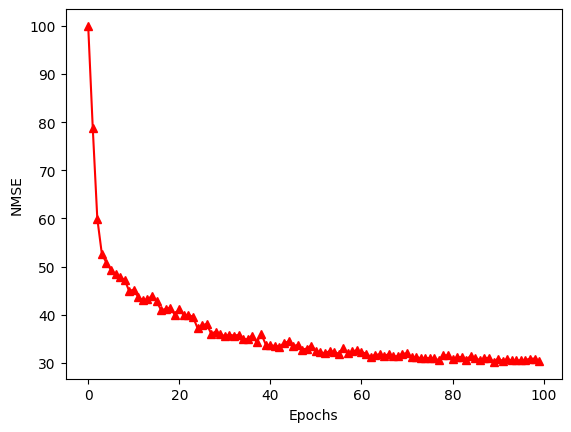

In [6]:
plt.figure()
plt.plot(np.arange(NUM_EPOCHS), nm, '^-r')
plt.xlabel('Epochs')
plt.ylabel('NMSE')
plt.show()